In [2]:
# importing all the libraries

import os
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

torch.manual_seed(99)
np.random.seed(99)



C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Directory containing the images
greypatridgespec = 'D:/college/8023/Analytathon 2/code/Goal1/greypartridgespec'
stockdovespec= 'D:/college/8023/Analytathon 2/code/Goal1//stockdovespec'
turtledovespec='D:/college/8023/Analytathon 2/code/Goal1/turtledovespec'
yellowhammerspec='D:/college/8023/Analytathon 2/code/Goal1/yellowhammerspec'

# List of all image file names in the directory
img_files_grey = os.listdir(greypatridgespec)
img_files_stock = os.listdir(stockdovespec)
img_files_turtle = os.listdir(turtledovespec)
img_files_yellow = os.listdir(yellowhammerspec)



In [4]:
grey_data=[]
for i,file_name in enumerate(img_files_grey):
    # Load the image
    img_path = os.path.join(greypatridgespec, file_name)
    img = Image.open(img_path)
    print(img.size) 

    img_arr = np.array(img, dtype=np.float32)
    # Normalize the pixel values to be between 0 and 1
    img_arr = img_arr / 255.0
    
    
    # greypatridgespec_labels.append(f'greypatridgespec_image_{i}')
    grey_data.append({'image':img_arr,'label':f'greypatridgespec'})


df_grey = pd.DataFrame(grey_data)
most_common_shape = df_grey['image'].apply(lambda x: x.shape).mode()[0]
df_filtered_grey = df_grey[df_grey['image'].apply(lambda x: x.shape) == most_common_shape]
df_filtered_grey= df_filtered_grey.sample(n=898)

(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(178, 128)
(216, 128)
(216, 128)
(216, 128)
(145, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(158, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(214, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(203, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(139, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(90, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(216, 128)
(123, 128)
(216, 128)


In [5]:
stock_data=[]
for i,file_name in enumerate(img_files_stock):
    # Load the image
    img_path = os.path.join(stockdovespec, file_name)
    img = Image.open(img_path)
    img_arr = np.array(img, dtype=np.float32)

    # Normalize the pixel values to be between 0 and 1
    img_arr = img_arr / 255.0
    
    
    # greypatridgespec_labels.append(f'greypatridgespec_image_{i}')
    stock_data.append({'image':img_arr,'label':f'stockdovespec'})


df_stock = pd.DataFrame(stock_data)
most_common_shape = df_stock['image'].apply(lambda x: x.shape).mode()[0]

df_filtered_stock = df_stock[df_stock['image'].apply(lambda x: x.shape) == most_common_shape]
print(df_filtered_stock.shape)

(898, 2)


In [6]:
turtle_data=[]
for i,file_name in enumerate(img_files_turtle):
    # Load the image
    img_path = os.path.join(turtledovespec, file_name)
    img = Image.open(img_path)
    img_arr = np.array(img, dtype=np.float32)

    # Normalize the pixel values to be between 0 and 1
    img_arr = img_arr / 255.0
    
    
    # greypatridgespec_labels.append(f'greypatridgespec_image_{i}')
    turtle_data.append({'image':img_arr,'label':f'turtledovespec'})


df_turtle = pd.DataFrame(turtle_data)
most_common_shape = df_turtle['image'].apply(lambda x: x.shape).mode()[0]

df_filtered_turtle = df_turtle[df_turtle['image'].apply(lambda x: x.shape) == most_common_shape]
print(df_filtered_turtle.shape)

(902, 2)


In [7]:
yellow_data=[]
for i,file_name in enumerate(img_files_yellow):
    # Load the image
    img_path = os.path.join(yellowhammerspec, file_name)
    img = Image.open(img_path)
    img_arr = np.array(img, dtype=np.float32)

    # Normalize the pixel values to be between 0 and 1
    img_arr = img_arr / 255.0
    
    
    # greypatridgespec_labels.append(f'greypatridgespec_image_{i}')
    yellow_data.append({'image':img_arr,'label':f'yellowhammerspec'})


df_yellow = pd.DataFrame(yellow_data)
most_common_shape = df_stock['image'].apply(lambda x: x.shape).mode()[0]

df_filtered_yellow = df_yellow[df_yellow['image'].apply(lambda x: x.shape) == most_common_shape]
print(df_filtered_yellow.shape)

(781, 2)


In [8]:
df_birds = pd.concat([df_filtered_grey,df_filtered_stock,df_filtered_turtle,df_filtered_yellow],ignore_index=True)
df_birds

,image,label
0,"[[0.59607846, 0.8666667, 0.8862745, 0.85490197...",greypatridgespec
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",greypatridgespec
2,"[[1.0, 0.7921569, 0.73333335, 0.7490196, 0.733...",greypatridgespec
3,"[[0.80784315, 0.91764706, 0.92941177, 0.894117...",greypatridgespec
4,"[[1.0, 1.0, 1.0, 1.0, 0.68235296, 0.60784316, ...",greypatridgespec
...,...,...
3474,"[[0.61960787, 0.83137256, 0.78039217, 0.815686...",yellowhammerspec
3475,"[[0.73333335, 0.7607843, 0.7490196, 0.8039216,...",yellowhammerspec
3476,"[[0.63529414, 0.7529412, 0.8235294, 0.77254903...",yellowhammerspec
3477,"[[1.0, 1.0, 0.93333334, 0.89411765, 0.8784314,...",yellowhammerspec


In [9]:
df_birds.shape

(3479, 2)

In [10]:
df_birds.head()

,image,label
0,"[[0.59607846, 0.8666667, 0.8862745, 0.85490197...",greypatridgespec
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",greypatridgespec
2,"[[1.0, 0.7921569, 0.73333335, 0.7490196, 0.733...",greypatridgespec
3,"[[0.80784315, 0.91764706, 0.92941177, 0.894117...",greypatridgespec
4,"[[1.0, 1.0, 1.0, 1.0, 0.68235296, 0.60784316, ...",greypatridgespec


In [11]:
train_images,test_images,train_labels,test_labels=train_test_split(df_birds.image,df_birds.label,test_size=0.2,random_state=42)

In [12]:
train_images=np.stack(train_images.values).astype('float32')
test_images=np.stack(test_images.values).astype('float32')


In [13]:
train_images.shape

(2783, 128, 216)

In [14]:
train_data=torch.tensor(train_images)
test_data=torch.tensor(test_images)
test_data.shape


torch.Size([696, 128, 216])

In [15]:
train_data

tensor([[[0.9725, 0.9647, 0.9490,  ..., 0.9647, 0.9569, 0.7608],
         [0.8706, 0.8549, 0.8667,  ..., 0.8314, 0.8471, 0.7608],
         [0.8235, 0.8235, 0.8000,  ..., 0.7961, 0.8118, 0.7529],
         ...,
         [0.5176, 0.7804, 0.7451,  ..., 0.7804, 0.7922, 0.4000],
         [0.5137, 0.8824, 0.8196,  ..., 0.7569, 0.7569, 0.4000],
         [0.5137, 0.8392, 0.8824,  ..., 0.7922, 0.7647, 0.4000]],

        [[0.7647, 0.9020, 0.9020,  ..., 0.8510, 0.8627, 0.9255],
         [0.6196, 0.7020, 0.7843,  ..., 0.7255, 0.7569, 0.7608],
         [0.5765, 0.6627, 0.6510,  ..., 0.6196, 0.6627, 0.6431],
         ...,
         [0.2275, 0.3961, 0.2588,  ..., 0.4275, 0.3843, 0.3098],
         [0.3294, 0.4431, 0.3020,  ..., 0.3804, 0.3529, 0.3804],
         [0.3490, 0.3333, 0.3098,  ..., 0.3451, 0.2863, 0.3843]],

        [[0.7765, 0.8275, 0.8275,  ..., 0.8588, 0.8824, 0.8510],
         [0.6706, 0.6824, 0.6902,  ..., 0.6824, 0.7373, 0.6941],
         [0.6745, 0.6824, 0.6392,  ..., 0.6745, 0.6824, 0.

In [16]:
train_images_reshaped = train_data.reshape(-1,1,128,216)
test_images_reshaped = test_data.reshape(-1,1,128,216)
train_images_reshaped.shape

torch.Size([2783, 1, 128, 216])

In [17]:
train_data[0].shape

torch.Size([128, 216])

In [18]:


from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)


train_label_data= torch.tensor(train_labels_encoded, dtype=torch.long)
test_label_data= torch.tensor(test_labels_encoded, dtype=torch.long)
print(train_labels,train_labels_encoded)



2678      turtledovespec
1206       stockdovespec
3439    yellowhammerspec
3244    yellowhammerspec
611     greypatridgespec
              ...       
1095       stockdovespec
1130       stockdovespec
1294       stockdovespec
860     greypatridgespec
3174    yellowhammerspec
Name: label, Length: 2783, dtype: object [2 1 3 ... 1 0 3]


In [19]:
test_labels_encoded

array([3, 1, 0, 1, 3, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 2, 1, 3, 1, 2, 0, 2, 2, 1, 0, 0, 2, 0, 0, 2, 2, 0, 3,
       0, 0, 1, 2, 3, 1, 0, 3, 0, 2, 0, 0, 3, 2, 0, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 3, 3, 3, 3, 3, 1, 3, 1, 2, 1, 0, 1, 2, 2, 1, 2, 2, 3, 1, 1,
       0, 2, 1, 0, 0, 1, 3, 2, 1, 0, 3, 0, 0, 1, 2, 0, 1, 1, 3, 1, 1, 2,
       0, 1, 0, 0, 2, 0, 0, 2, 0, 3, 1, 0, 1, 1, 0, 1, 3, 2, 3, 2, 2, 1,
       2, 1, 0, 1, 0, 2, 3, 0, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2, 3, 3, 1, 1,
       1, 0, 2, 2, 2, 3, 0, 0, 3, 0, 0, 3, 2, 0, 1, 2, 2, 0, 0, 3, 1, 3,
       3, 1, 0, 3, 1, 2, 0, 3, 3, 2, 3, 3, 3, 3, 3, 0, 2, 1, 3, 3, 1, 0,
       2, 0, 1, 1, 0, 1, 0, 3, 1, 1, 0, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2,
       2, 2, 3, 2, 1, 0, 0, 3, 3, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 2, 0, 1, 3, 3, 1, 0, 2, 1, 0, 2, 0, 2, 0,
       2, 2, 1, 0, 3, 0, 2, 1, 3, 1, 1, 3, 1, 0, 0, 3, 1, 2, 2, 0, 0, 1,
       0, 3, 2, 2, 2, 0, 2, 1, 2, 2, 3, 1, 2, 0, 0,

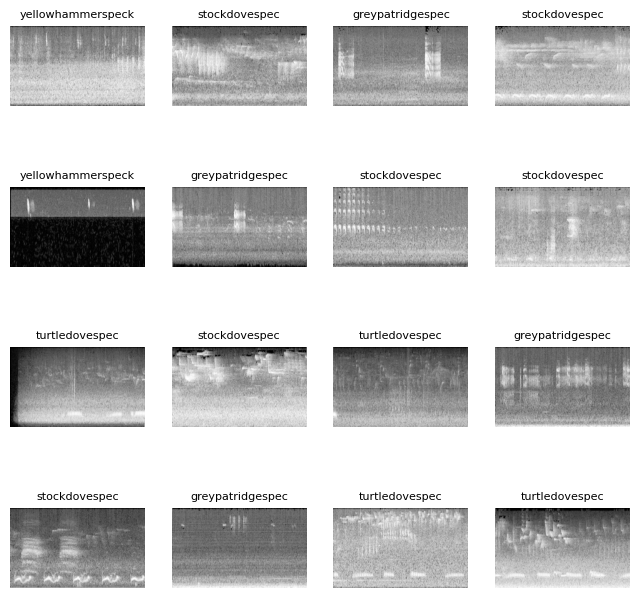

In [20]:
classes=['greypatridgespec','stockdovespec','turtledovespec','yellowhammerspeck']

fig,axs = plt.subplots(4,4,figsize=(8,8))
axs = axs.flatten()
for n,ax in enumerate(axs):
    ax.imshow(test_data[n],cmap="Greys")
    ax.set_title(classes[test_label_data[n]],fontsize=8)
    ax.axis('off')

# normalize data

In [21]:
train_dataset =TensorDataset(train_label_data,train_images_reshaped)
test_dataset =TensorDataset(test_label_data,test_images_reshaped)

batch_size=128

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True) 

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn= nn.Sequential(
        #     nn.Conv2d(1,16,3,stride=1,padding=1),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),  
        #     nn.Dropout(0.4),
        #     nn.Conv2d(16, 16, 3, stride=1, padding=1),  
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),  
        #     nn.Flatten(),
        #     nn.Dropout(0.4),
        #     nn.Linear(27648, 200),
        #     nn.BatchNorm1d(200),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(200, 4),
        # 

            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2),  
            nn.Dropout(0.4),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2),  
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),  
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(27648, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 4),
        )

        

    def forward(self, x):
        # print(x.shape)
        out = self.cnn(x)
      
        return out
    
# cnn= CNN()

# x= torch.randn(4,1,128,216)
# y=cnn(x)
# print(y.shape)


torch.Size([4, 4])


In [23]:
num_epoches=5

n_pixels=128*216

def train_old(model,train_loader_data,loss_function,optimizer):
    size=len(train_loader_data.dataset)
    model.train()
    train_loss=0
    for batch, (labels,images) in enumerate(train_loader_data):
        optimizer.zero_grad()

        output=model(images.float())
        loss=loss_function(output,labels)
        loss.backward()
        optimizer.step()


        if batch %100 == 0:
            loss,current=loss.item(),batch*len(images)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

            

        

In [24]:
def test(model, test_data,loss_fn):
    size = len(test_data.dataset)
    num_batches = len(test_data)
    model.eval()
    test_loss = 0
    correct = 0
    
    label_array = np.zeros(len(test_dataset))
    pred_array = np.zeros(len(test_dataset))
    n=0
    with torch.no_grad():
        for labels,images in test_data:
            pred = model(images.float())
            pred_labels = pred.argmax(1)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred_labels == labels).sum().item()

            for label, prediction in zip(labels, pred_labels):
                
                label_array[n] = label
                pred_array[n] = prediction
                n=n+1
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return label_array, pred_array

In [25]:
for batch, (labels,images) in enumerate(test_loader):
     print(batch)
     print(labels)
     print(images.shape)
     break


0
tensor([3, 0, 3, 2, 3, 0, 0, 3, 3, 3, 1, 3, 0, 3, 3, 0, 3, 1, 0, 2, 2, 0, 0, 1,
        2, 1, 0, 1, 3, 3, 2, 2, 0, 1, 1, 3, 0, 0, 3, 2, 0, 2, 3, 1, 0, 2, 1, 1,
        2, 3, 3, 2, 1, 1, 2, 0, 2, 3, 1, 1, 1, 2, 0, 2, 0, 2, 1, 1, 2, 2, 3, 1,
        1, 2, 2, 1, 1, 1, 3, 0, 1, 3, 2, 0, 2, 1, 0, 1, 3, 3, 0, 0, 0, 3, 0, 0,
        3, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 1, 3,
        3, 0, 0, 3, 3, 3, 1, 2])
torch.Size([128, 1, 128, 216])


In [26]:
num_epochs = 5
n_pixels = 128*216
num_classes = 4

def train(model,train_loader,test_loader,num_epochs,optimizer):
    criterion = nn.CrossEntropyLoss()
    
    epochs, epoch_loss, epoch_val_loss, epoch_accuracy= [],[],[],[]
    for n in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx,(labels, data) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(data.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        train_loss = train_loss/(batch_idx+1)
        epoch_loss.append(train_loss)
        model.eval()  
        correct = 0
        total = 0
        loss_list = []
        with torch.no_grad():
            for batch_idx,(labels, data) in enumerate(test_loader):
                outputs = model(data.float())
                loss = criterion(outputs, labels)
                loss_list.append(loss)
                correct += (outputs.argmax(1) == labels).sum().item()
                total += len(labels)
                
        val_loss = np.mean(loss_list)
        epoch_val_loss.append(val_loss)
        accuracy = correct/total  
        epoch_accuracy.append(accuracy*100)
        epochs.append(n+1)
        print(f'{n+1} / {num_epochs}: loss {train_loss:0.03f}, val_loss {val_loss:0.03f}, accuracy {accuracy:0.03f}')
        
    fig,axs = plt.subplots(1,2,figsize=(16,5))
    axs[0].plot(epochs,epoch_loss,label='train')
    axs[0].plot(epochs,epoch_val_loss,label='val')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[1].plot(epochs,epoch_accuracy)
    axs[1].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')


In [39]:
model = CNN()
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# for epoch in range(1,6):
#     print(f"Epoch {epoch}\n-------------------------------")
train(model,train_loader,test_loader,15,optimizer)

print("Done!")

In [28]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(1,15):
    print(f"Epoch {epoch}\n-------------------------------")
    train_old(model,train_loader,loss_fn,optimizer)
    test(model,test_loader,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.418315 [    0/ 2783]
Test Error: 
 Accuracy: 38.8%, Avg loss: 1.181814 

Epoch 2
-------------------------------
loss: 0.634566 [    0/ 2783]
Test Error: 
 Accuracy: 63.2%, Avg loss: 0.873045 

Epoch 3
-------------------------------
loss: 0.466014 [    0/ 2783]
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.714673 

Epoch 4
-------------------------------
loss: 0.401428 [    0/ 2783]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.696958 

Epoch 5
-------------------------------
loss: 0.311961 [    0/ 2783]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.610573 

Epoch 6
-------------------------------
loss: 0.355471 [    0/ 2783]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.616877 

Epoch 7
-------------------------------
loss: 0.168855 [    0/ 2783]
Test Error: 
 Accuracy: 72.4%, Avg loss: 0.756212 

Epoch 8
-------------------------------
loss: 0.225173 [    0/ 2783]
Test Error: 
 Accuracy: 70.3%, Avg loss: 0.800213 

Epoch 9
------------------------

In [29]:
n_param = 0
for parameter in model.parameters():
    n_param+=np.prod(parameter.shape)
n_param

5533548

torch.Size([128, 1, 128, 216])


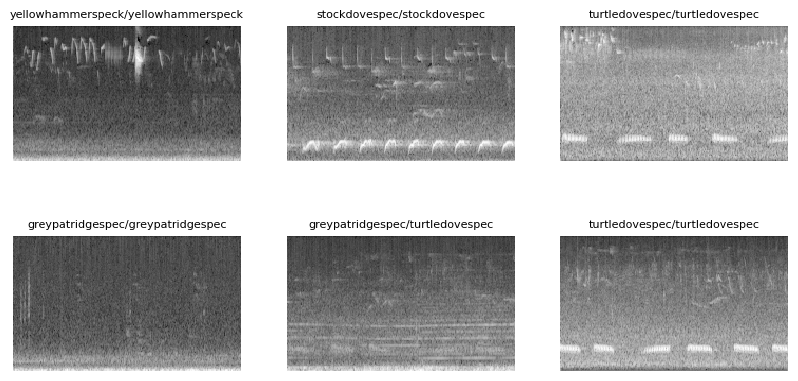

In [30]:
test_enumerator = enumerate(test_loader)
batch_idx, (labels,images) = next(test_enumerator)
# batch_idx, (images, labels) = next(test_enumerator)
print(images.shape)

pred_labels = model(images).argmax(1)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
axs = axs.flatten()
for n, ax in enumerate(axs):
    ax.set_axis_off()
    ax.imshow(images[n][0], cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(classes[pred_labels[n]] + '/' + classes[labels[n]],fontsize=8)
    

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.612619 



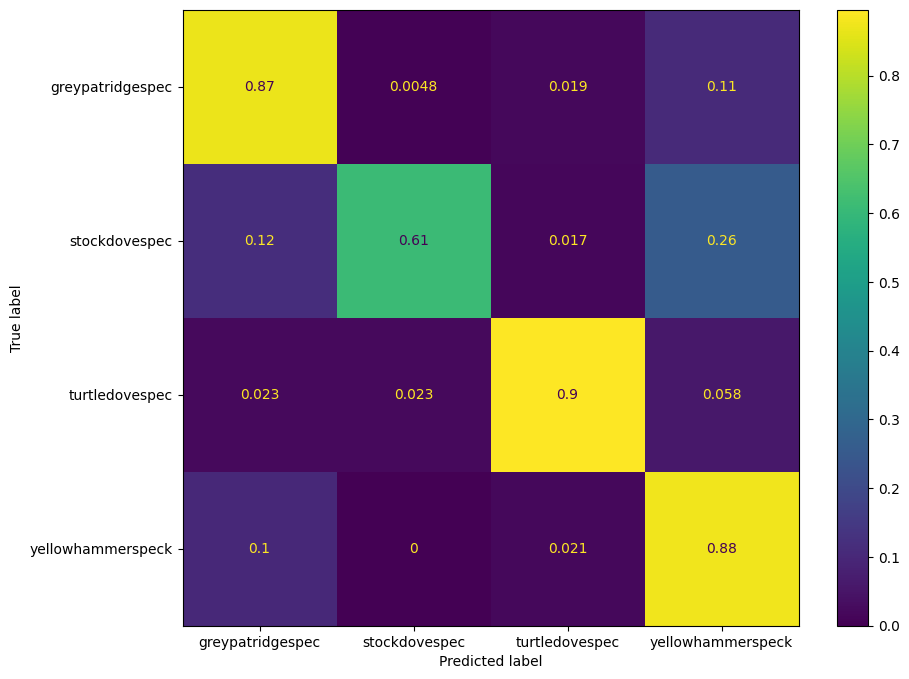

In [31]:
loss_fn=nn.CrossEntropyLoss()
label_array, pred_array = test(model,test_loader,loss_fn)

from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(label_array, pred_array,
                display_labels=classes,
                normalize='true')
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(10)